In [1]:
import os
import pandas as pd
import numpy as np
import skimage.io
import PIL
from tqdm.notebook import tqdm
import cv2
import random
import matplotlib.pyplot as plt
import joblib


path = 'C:\\Users\\pka\\panda_kaggle'
path_train = 'D:\\prostate-cancer-grade-assessment\\train_images'
path_mask = 'D:\\prostate-cancer-grade-assessment\\train_label_masks'

In [2]:
list_name =[
    '07a14fa5b8f74272e4cc0a439dbc8f7f',
    '0bd231c85b2695e2cf021299e67a6afc',
    '0da0915a236f2fc98b299d6fdefe7b8b',
    '0e5806abc1cf909123d584e504dd9bf9',
    '0e62a4cba998a03d20295e07ebc30958',
    '0f1ea91c9f917bb3d198f02fd432e4ce',
    '158754df49e00760f8e4659a05e7cc0c',
    '16ad51c0a769aa6dd7d09671faca0b4e',
    '170c91c206648c545cfe69c718c059f2',
    '1aa5ff56e243cbc8ed0e140a7148f3fd',
    '1d432fcf31474114a1f5f12268b9a1ab',
    '28d2e92f40bdd98d7cd5275fa448fe2d',
    '29d140073e1fe204faacd8b1ff2086d8',
    '2ae016457e8ff8e21723a91b57a96d7d',
    '35c7912e941c9bf21594deeda6c891e2',
    '389a3fcfddfbd92bdcb69da5b10d383c',
    '3a6161c02efaf0c49fe4dc6ffd76c838',
    '3d459935dae8bbeb5bda9cfc40e4b3ab',
    '3e3d938e4279c4339473f26a7eb5020e',
    '432ec3aa0403cfd011d4489879fada9c',
    '4502c2c9c9c1041564225b9d8fad13c1',
    '46bf558b24bcdfe1f3ae711b02b53a63',
    '4e60bebc14d01b30a0873ba7ee026dac',
    '4f8506ad3366270f12cd7a31641495cb',
    '5204134e82ce75b1109cc1913d81abc6',
    '549f87924e4800a7112f6edd5c250ebe',
    '5ecebd2186ad8871c59a607bbd6d3a6d',
    '60a18d14b13eb21b56f3d3e77a315af7',
    '623055537fd299a566acf58214ae2133',
    '62a976bdc21bd2c8a34de5ec3d192857',
    '6844032932a3939565e936a523174b6d',
    '6a43f7e8b37e4f8a63ba3f178ef78016',
    '6cbc6f7259cb45a4086cd584aec53857',
    '6e229bc5d46c2bb07cb0ab6b64c30a48',
    '77545268b9c0cec2fd73b7cb9e03d66b',
    '7c03cedfde9bdd397d67c010fe7e61e2',
    '7c90a7a9ea4b644c26fa03ffd564676c',
    '886682be4f834c17abfcbd5137374279',
    '88e65e1d716893e6efdbd2464b3686fa',
    '8d5860e10e09ee25e066ee7fb699453d',
    '8d96e24f96029fb89ad33d017f1fbcfc',
    '94e121bc4a7091b881e8dd9b6c2be6b5',
    '99df939d41052c33bbd4af1bb923846d',
    '9a4ba048c62623465d6a7a0d8549a657',
    '9c24ae764d87098d03faccc2e2a579d0',
    '9e40b83c6ac2b92e2426b717ed1a200e',
    '9e9ace16f4d20d98a65d3936b953f442',
    'acc092b7ff833d1d9853a2efe449e66e',
    'b99ca5db00eca6566d106abce9cba70c',
    'bd31a494912d04160fec50b16a4d330f',
    'bf779325c9c16f04957839ba92518ab8',
    'bfc6ccb20af434cfb505aafc00dce754',
    'c0d0ba963f8eb0021719349ef60c1aa6',
    'c60d25e72004ddd6bc308d3a42ce6dba',
    'c6cf6f5137c7c67a77ea6a9f1ef73999',
    'cb91772271b72c237c42f64fb6d2e84e',
    'ce9932f7fb31128b15ef9390cc78fe4b',
    'd0115a12026bc4b8a10ad05fe4992ded',
    'd14168b713f3ba30243a69837a001115',
    'd67b041b85b44bdde7dc852dcbc70033',
    'd7b7b3e3d85c768d7a453e50679f2a80',
    'ddd302c374af146eeff0408e2b5da995',
    'e6ba38a0847082104bfcbd7ec1bf6f49',
    'e702bc96a10e3ff51dca2e8eef71e4af',
    'f1a7f32a0a9ed7c50796a10e150df72b'
]

drop = [
    'fa7ece1587e37e28416110063cc5266a',
    'fc20aec4fd0c2f9017888dd94feb84ee'
   
]

df = pd.read_csv(os.path.join(path, 'train.csv'))
df = df[~df.image_id.isin(drop)]

In [22]:
def mask_idx(img, sz = 224):
    """
    img : image mask format img[:, :, 0]
    sz : size to cut image
    
    Два  варианта все значения(индексы), или так сказать более детальные маски
    
    return all_idx, idx
    """
    if img is None: return [], []
    
    idx_all, idx =  [], []
    img = img[:, :, 0]
    #make vert
    h, w = img.shape
    #pad
    pad_h, pad_w = (sz- img.shape[0]%sz)%sz, (sz- img.shape[1]%sz)%sz 
    img = np.pad(img,
             [
                 [pad_h//2, pad_h-pad_h//2],
                 [pad_w//2, pad_w-pad_w//2],
              ],
                 constant_values = 255)
    #reshape (14, 256, 5, 256)
    img = img.reshape(img.shape[0]//sz, sz, img.shape[1]//sz, sz)
    img = np.transpose(img, (0,2,1,3)).reshape(-1, sz, sz) # (70, 256, 256) 

    for i in range(img.shape[0]):
        if len(np.unique(img[i].reshape(-1))) > 3:
            idx.append(i)            
            
        if len(np.unique(img[i].reshape(-1))) >= 3:
            idx_all.append(i)

    return idx_all, idx         

def image_pad(img, img_mask, mode = 0, sz =224):  
    # 21*224*224 # 1053696
    # 16*256*256 # 1048576
    n = 36 #21    
    h, w, c = img.shape        
    pad_h, pad_w = (sz - h%sz)%sz, (sz - w%sz)%sz
    img = np.pad(img,
                 [
                     [pad_h//2, pad_h-pad_h//2],
                     [pad_w//2, pad_w-pad_w//2],
                     [0,0]
                 ],
                 constant_values = 255)
    img = img.reshape(img.shape[0]// sz, sz, img.shape[1]// sz, sz, 3) # (4, 256, 2, 256, 3)
    img = img.transpose(0,2,1,3,4).reshape(-1,sz,sz,3) #(4, 2, 256, 256, 3)--> (8, 256, 256, 3)

    idx_default = np.argsort(img.reshape(img.shape[0],-1).sum(-1))

#     if mode == 0:  
#         #print(f'Mode : {mode}')        
#         return img[idx_default[:16]]
    
    idx_all, idx = mask_idx(img_mask, sz = sz)
    
    #set index_default - idx 
    #what diff idx for idx_default
    #after add diff to idx
    
    #mode = 1
    
    if len(idx) >= n:
        
        return img[idx[:n]]    
    
    if len(idx) > 0:
        diff = set(idx_default) - set(idx)
        count_add = abs(len(idx) - len(diff))
        x = np.append(idx, idx_default[:count_add])
        
        if len(x) >= n:            
            return img[x[:n]]
        
        if (len(x) < n) & (len(idx_default) >= n):
            return img[idx_default[:n]]       
        else:
            if sum([len(x), len(idx_default)]) >= n:
                not_u = np.append(x, idx_default)                
                return img[not_u[:n]]
    else:
        if len(idx_default) >= n:
            return img[idx_default[:n]]
        else:            
            img = np.pad(img,[[0, n-len(img)],[0,0],[0,0],[0,0]], constant_values=255)            
            return img

In [19]:
name
image = skimage.io.MultiImage(os.path.join(path_train, f'{name}.tiff'))[1]
#~50 no mask file skip
image_mask = skimage.io.MultiImage(os.path.join(path_mask, f'{name}_mask.tiff'))[1]
image = image_pad(image, image_mask, 1, 224)    
image.shape

45


(36, 224, 224, 3)

In [ ]:
#df = df.sample(50)

(<matplotlib.image.AxesImage at 0x25516db7a48>, (21, 224, 224, 3))

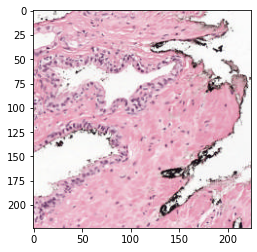

In [13]:
image = skimage.io.MultiImage(os.path.join(path, '004dd32d9cd167d9cc31c13b704498af.tiff'))[1]
image_mask = skimage.io.MultiImage(os.path.join(path, f'004dd32d9cd167d9cc31c13b704498af_mask.tiff'))[1]
image = image_pad(image, image_mask, 1, 224)
plt.imshow(image[20]), image.shape

In [14]:
import zipfile
n = 21
OUT_TRAIN = 'train.zip'
with zipfile.ZipFile(OUT_TRAIN, 'w') as img_out:
    #skip mask not need only in mode 1
    for i in tqdm(range(len(df))):
        name = df['image_id'].values[i]
        if name not in list_name:            
            try:
                image = skimage.io.MultiImage(os.path.join(path_train, f'{name}.tiff'))[1]
                #~50 no mask file skip
                image_mask = skimage.io.MultiImage(os.path.join(path_mask, f'{name}_mask.tiff'))[1]
            except:
                image_mask = None
            image = image_pad(image, image_mask, 1, 224) 
        else:            
            try:
                image = skimage.io.MultiImage(os.path.join(path_train, f'{name}.tiff'))[0]
                image_mask = skimage.io.MultiImage(os.path.join(path_mask, f'{name}_mask.tiff'))[0]
            except:
                image_mask = None                
            image = image_pad(image, image_mask, 1, 224)

        for i in range(36):
            img = image[i]
            file_name = f'{name}_{i}.png'
            #np.save(file_name, img)    
            img = cv2.imencode('.png',img)[1]
            img_out.writestr(file_name, img)            

In [ ]:
# z = zipfile.ZipFile('./train.zip', 'r')
# z.printdir()
# z.extract('0005f7aaab2800f6170c399693a96917_21.png')

In [ ]:
# image = './0005f7aaab2800f6170c399693a96917_17.png'
# a = cv2.imdecode(image, cv2.IMREAD_COLOR)
# plt.imshow(a)

In [5]:
import joblib

In [11]:
#10614, stop when  no hhd space

n = 16
for i in tqdm(range(len(df))):
    name = df['image_id'].values[i]    
    if name not in list_name:            
        try:
            image = skimage.io.MultiImage(os.path.join(path_train, f'{name}.tiff'))[1]
            #~50 no mask file skip
            image_mask = skimage.io.MultiImage(os.path.join(path_mask, f'{name}_mask.tiff'))[1]
        except:
            image_mask = None
        image = image_pad(image, image_mask, 1, 224) 
    else:            
        try:
            image = skimage.io.MultiImage(os.path.join(path_train, f'{name}.tiff'))[0]
            image_mask = skimage.io.MultiImage(os.path.join(path_mask, f'{name}_mask.tiff'))[0]
        except:
            image_mask = None                
        image = image_pad(image, image_mask, 1, 224)
    row = int(np.sqrt(n))
    blank_image = np.zeros((224*row, 224*row, 3))
    for h in range(row):
        for w in range(row):
            i = h * row + w       
            if len(image) > i: #<21
                img = image[i]
            else:
                img = np.ones((224, 224, 3)).astype(np.uint8) * 255                   
            #add to z_image
            h1 = h * 224
            w1 = w * 224 
            #print(img.shape)
            blank_image[h1: h1+224, w1: w1+224] = img /255
    #np.save(f'C:\\Users\\pka\\kaggle\\panda\\npy_25\\{name}', blank_image)
    joblib.dump(blank_image, f'C:\\Users\\pka\\kaggle\\panda\\pkl_16\\{name}.pkl')

In [9]:
img = '0005f7aaab2800f6170c399693a96917.npy'
image = np.load('C:\\Users\\pka\\' + img) 
img = image.reshape(6, 224, 6,224,3)
img = np.transpose(img, (0,2,1,3,4)).reshape(-1, 224,224, 3)


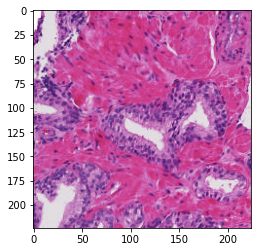

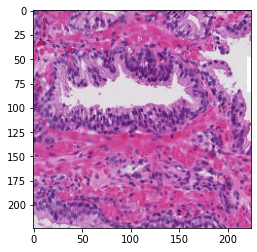

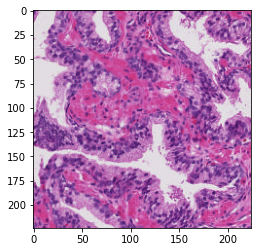

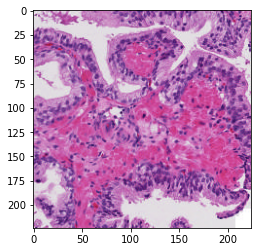

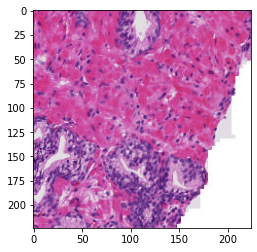

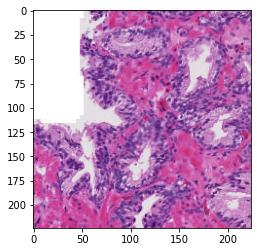

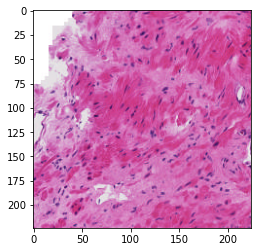

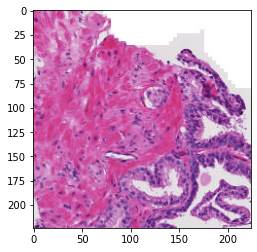

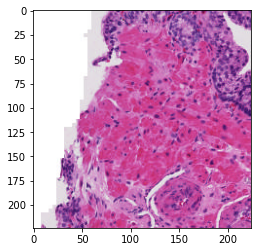

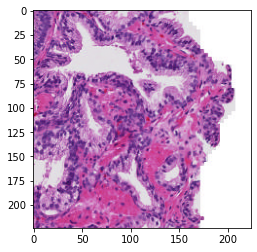

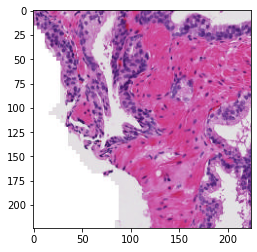

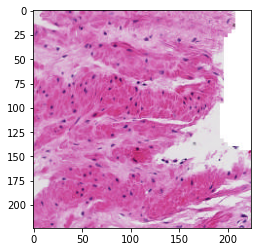

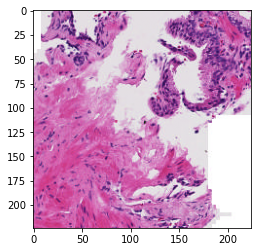

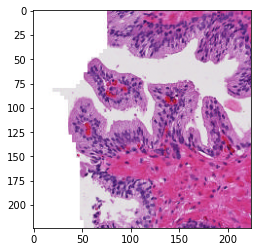

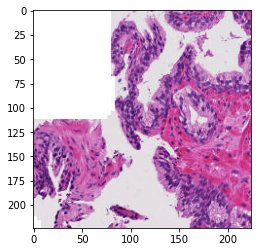

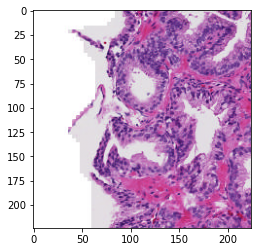

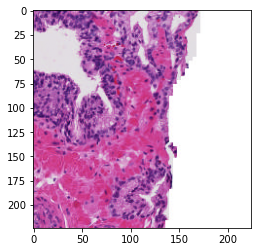

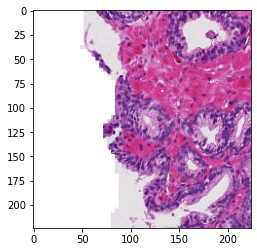

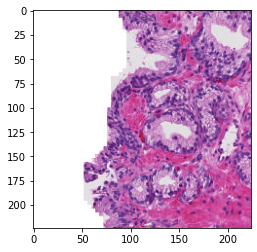

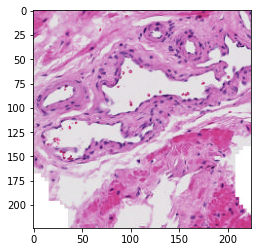

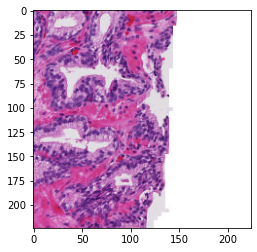

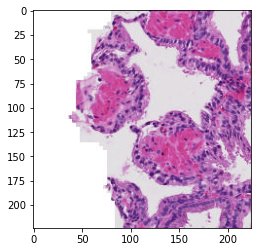

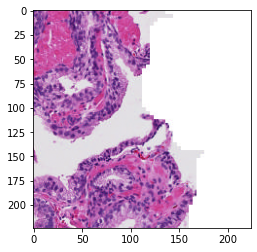

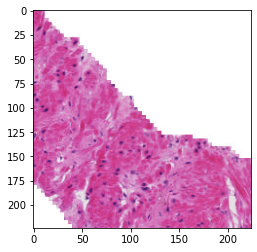

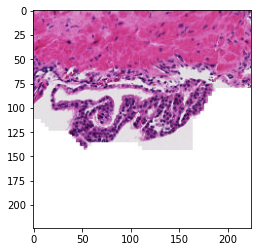

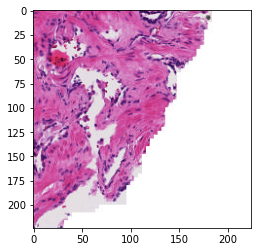

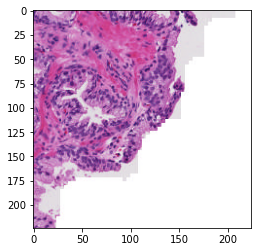

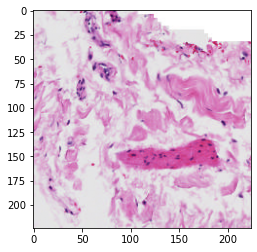

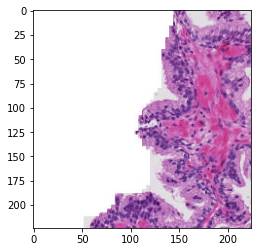

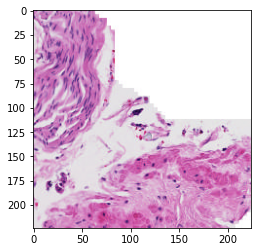

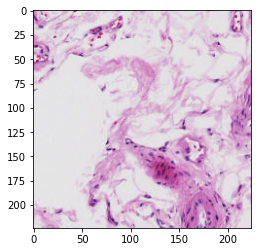

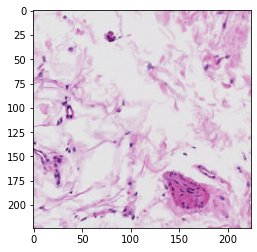

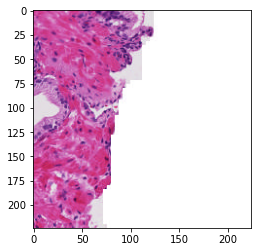

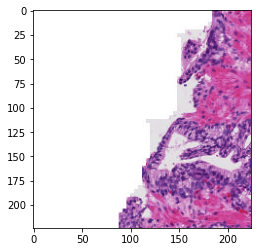

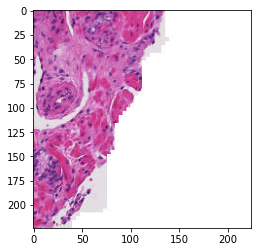

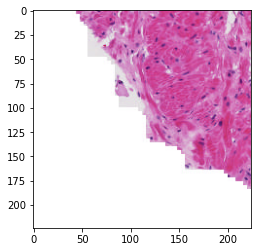

In [13]:
for i in range(n):
    plt.imshow(img[i])
    plt.show()

In [19]:
name = '000920ad0b612851f8e01bcc880d9b3d.pkl'
img = joblib.load(f'C:\\Users\\pka\\kaggle\\panda\\pkl_25\\{name}')

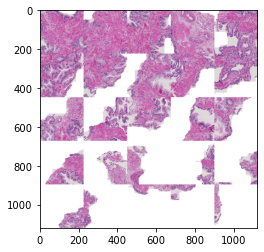

In [20]:
plt.imshow(img)

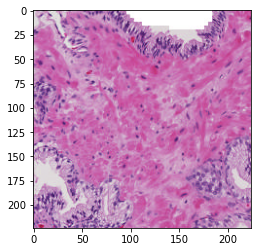

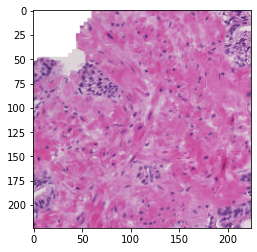

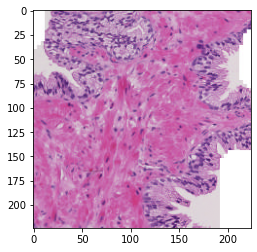

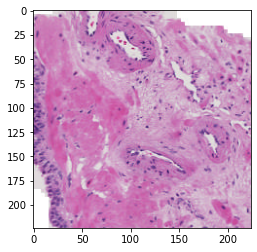

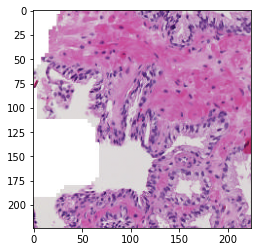

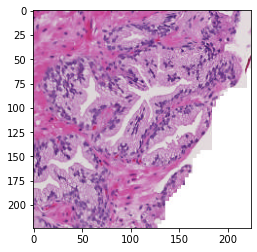

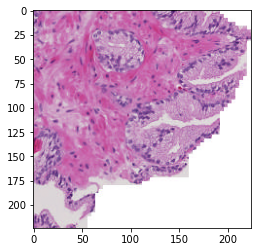

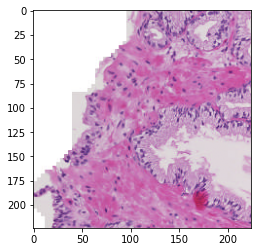

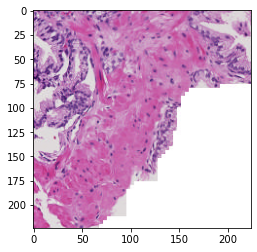

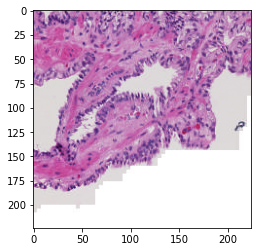

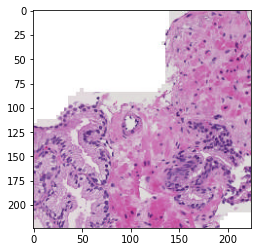

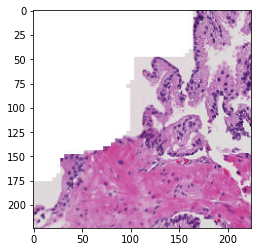

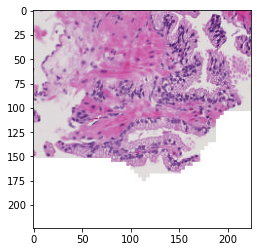

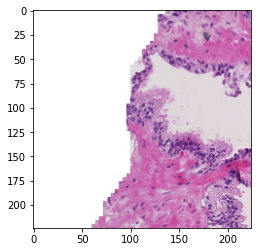

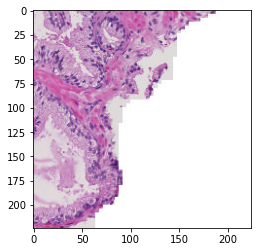

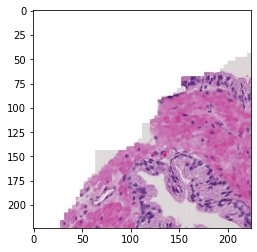

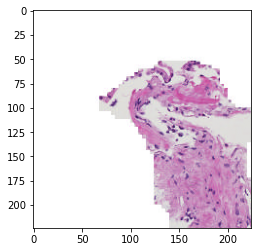

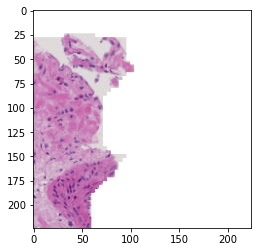

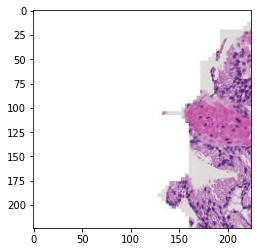

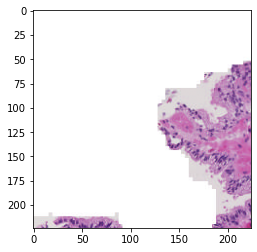

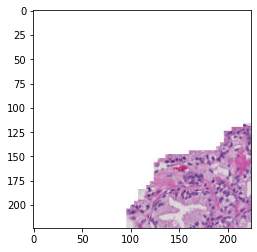

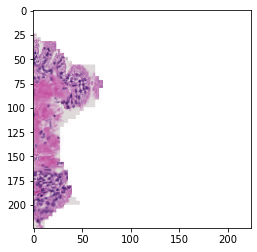

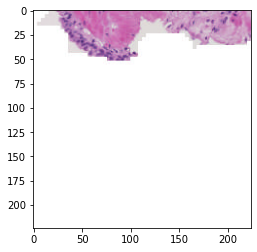

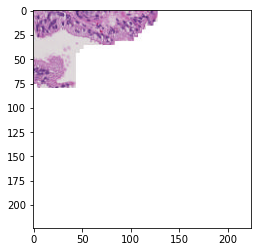

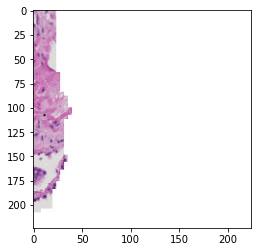

In [21]:
img = img.reshape(5, 224, 5,224,3)
img = np.transpose(img, (0,2,1,3,4)).reshape(-1, 224,224, 3)
for i in range(n):
    plt.imshow(img[i])
    plt.show()

In [31]:
n = 36
#10367, 'fa7ece1587e37e28416110063cc5266a'
for i in tqdm(range(10367, 10616)):
    name = df['image_id'].values[i]  
    with open(f'C:\\Users\\pka\\kaggle\\panda\\log\\names_save.txt', 'a') as appender:
                appender.write(name + '\n') 
    if name not in list_name:            
        try:
            image = skimage.io.MultiImage(os.path.join(path_train, f'{name}.tiff'))[1]
            #~50 no mask file skip
            image_mask = skimage.io.MultiImage(os.path.join(path_mask, f'{name}_mask.tiff'))[1]
        except:
            image_mask = None
        image = image_pad(image, image_mask, 1, 224) 
    else:            
        try:
            image = skimage.io.MultiImage(os.path.join(path_train, f'{name}.tiff'))[0]
            image_mask = skimage.io.MultiImage(os.path.join(path_mask, f'{name}_mask.tiff'))[0]
        except:
            image_mask = None                
        image = image_pad(image, image_mask, 1, 224)    
    for i in range(n):
        img = image[i]
        joblib.dump(img, f'C:\\Users\\pka\\kaggle\\panda\\pkl_36\\{name}_{i}.pkl')

IndexError: index 10614 is out of bounds for axis 0 with size 10614

In [32]:
len(df)

10614

In [ ]:
n = 16
for i in tqdm(range(len(df))):
    name = df['image_id'].values[i]    
    if name not in list_name:            
        try:
            image = skimage.io.MultiImage(os.path.join(path_train, f'{name}.tiff'))[1]
            #~50 no mask file skip
            image_mask = skimage.io.MultiImage(os.path.join(path_mask, f'{name}_mask.tiff'))[1]
        except:
            image_mask = None
        image = image_pad(image, image_mask, 1, 224) 
    else:            
        try:
            image = skimage.io.MultiImage(os.path.join(path_train, f'{name}.tiff'))[0]
            image_mask = skimage.io.MultiImage(os.path.join(path_mask, f'{name}_mask.tiff'))[0]
        except:
            image_mask = None                
        image = image_pad(image, image_mask, 1, 224)
    row = int(np.sqrt(n))
    blank_image = np.zeros((224*row, 224*row, 3))
    for h in range(row):
        for w in range(row):
            i = h * row + w       
            if len(image) > i: #<21
                img = image[i]
            else:
                img = np.ones((224, 224, 3)).astype(np.uint8) * 255                   
            #add to z_image
            h1 = h * 224
            w1 = w * 224 
            #print(img.shape)
            blank_image[h1: h1+224, w1: w1+224] = img /255
    #np.save(f'C:\\Users\\pka\\kaggle\\panda\\npy_25\\{name}', blank_image)
    joblib.dump(blank_image, f'C:\\Users\\pka\\kaggle\\panda\\pkl_16\\{name}.pkl')

In [3]:
"""
this test correct load image to learn

"""

n = 16
for i in tqdm(range(len(df))):
    name = df['image_id'].values[i]  
    row = int(np.sqrt(n))        
    blank_image = np.zeros((224*row, 224*row, 3))
    j = 0
    b = 0    
    for i in range(1, n + 1):
        image = joblib.load(f'C:\\Users\\pka\\kaggle\\panda\\pkl_36\\{name}_{i-1}.pkl')
        h = i - b
        w = j    
        if (i != 0) & (i % int(np.sqrt(n)) == 0):      
            j += 1
            b += int(np.sqrt(n))    
        h1 = abs(h-1) * 224
        w1 = w * 224    
        blank_image[h1: h1+224, w1: w1+224] = image 
    np.save(f'C:\\Users\\pka\\kaggle\\panda\\npy_16\\{name}', blank_image)